In [143]:
from __future__ import division

from pylab import *
import scipy
import time
import utils
import hrr_utils
import RM_utils
import utilities.colormaps

#import imnet_utils as imut
import sklearn
from sklearn.decomposition import PCA, FastICA, TruncatedSVD, NMF
from scipy import stats

%matplotlib inline

plt.rcParams.update({'axes.titlesize': 'xx-large'})
plt.rcParams.update({'axes.labelsize': 'xx-large'})
plt.rcParams.update({'xtick.labelsize': 'x-large', 'ytick.labelsize': 'x-large'})
plt.rcParams.update({'legend.fontsize': 'x-large'})
plt.rcParams.update({'text.usetex': True})

In [144]:
def ngram_encode(ngram_str, letter_vecs, alph):
    vec = np.zeros(letter_vecs.shape[1])
    
    full_str = '#' + ngram_str + '.'
    
    
    for il, l in enumerate(full_str[:-2]):
        trivec = letter_vecs[alph.find(full_str[il]), :]
        for c3 in range(1, 3):
            trivec = trivec * np.roll(letter_vecs[alph.find(full_str[il+c3]), :], c3)
            
        vec += trivec
    return vec

def ngram_encode_cl(ngram_str, letter_vecs, alph):
    vec = ngram_encode(ngram_str, letter_vecs, alph)
    return 2* (vec + 0.1*(np.random.rand(letter_vecs.shape[1])-0.5) > 0) - 1

def sim(x, y):
    if len(x.shape) == 1 or len(y.shape)==1:
        return np.dot(x, y)
    return np.sum(np.multiply(x, y), axis=1)

def initialize(letter_vecs, N, D, state_length=5, n_steps=500):
    states = []
    coef_hists = []
    
    for i in range(state_length):
        states.append(np.random.randn(N))
    
    for i in range(1, state_length-1):
        states[i] = np.dot(letter_vecs.T, np.dot(states[i], letter_vecs.T))

    for i in range(1, state_length-1):
        states[i] = states[i]/norm(states[i])

    states[0] = letter_vecs[alph.find('#'), :]
    states[state_length-1] = letter_vecs[alph.find('.'), :]
    
    for i in range(1, state_length-1):
        coef_hists.append(np.zeros((n_steps, D)))
    
    return states, coef_hists

def explain_away(bound_vec, states, coef_hists, state_length, letter_vecs, N, D, max_steps=500):
    th_vec = bound_vec.copy()

    for i in range(max_steps):

        for j in range(1, state_length-1):
            coef_hists[j-1][i, :] = np.dot(letter_vecs, states[j])
        
        for j in range(1, state_length-1):
            mxidx = np.argmax(np.abs(coef_hists[j-1][i,:]))
            states[j] *= np.sign(coef_hists[j-1][i, mxidx])
        ljds = []
        for j in range(1, state_length-1):
            if j == 1:
                ljds.append(
                    (np.roll(th_vec * states[0] * np.roll(states[2], 2), -1) +
                    th_vec * np.roll(states[2], 1) * np.roll(states[3], 2)) / 2
                )
            elif 1 < j < state_length-2:
                ljds.append(
                    (np.roll(th_vec * states[j-2] * np.roll(states[j-1], 1), -2) +
                    np.roll(th_vec * states[j-1] * np.roll(states[j+1], 2), -1) +
                      th_vec * np.roll(states[j+1], 1) * np.roll(states[j+2], 2)) / 3
                )
            else:
                ljds.append(
                    (np.roll(th_vec * states[j-1] * np.roll(states[j+1], 2), -1) +
                   np.roll(th_vec * states[j-2] * np.roll(states[j-1], 1), -2)) / 2
                )

        for j in range(1, state_length-1):    
            states[j] = np.dot(letter_vecs.T, np.dot(ljds[j-1], letter_vecs.T)/N) + 1.0*states[j]
        
        bv = states[0] * np.roll(states[1],1) * np.roll(states[2],2)  
        for j in range(1, state_length-2):
            bv += states[j] * np.roll(states[j+1],1) * np.roll(states[j+2],2) 
         
        th_vec = bound_vec - bv

    return states, coef_hists

def spell(coef_hists):
    pred = ''
    alphis = []

    for i in range(len(coef_hists)):
        x, alphi = np.unravel_index(coef_hists[i].argmax(), coef_hists[i].shape)
        pred += alph[alphi]
        alphis.append(alphi)

    return pred, alphis
    
def resplot(word_length, states, coef_hists, N, nsteps, start):
    
    pred, alphis = spell(coef_hists)
    print pred
    rows = 1
    columns = word_length

    fig, axes = plt.subplots(rows, columns, sharex='all', squeeze=True, figsize=(25,5))
    cols = get_cmap('copper', min(500,n_steps))
    x = np.linspace(0,len(alph)-2,len(alph)-2)
    labels = list(alph)
    plt.xticks(x, labels)
    
    for j in range(word_length):
        for i in range(start, min(500,n_steps)):
            # graphing the max positive at every iteration is not intuitive, since we should
            # be focusing on how our predicted letter's probability increases over time
            coef_hists[j][i,alphis[j]] = np.abs(coef_hists[j][i,alphis[j]])
            axes[j].plot(coef_hists[j][i,:], lw=1.7, c=cols(i))
            
        step, alphi = np.unravel_index(coef_hists[j].argmax(), coef_hists[j].shape)
        axes[j].plot(alphi, coef_hists[j][step, alphi], '+')

    #plt.savefig('figures/'+title+pred+'-N='+str(N)+'-steps='+str(nsteps)+'-reg='+reg+'.svg')
    
def accuracy(pred, actual):
    acc = 0
    for i in range(len(pred)):
        if pred[i] == actual[i]:
            acc += 1
    return acc / float(len(pred))


In [146]:
alph = 'abcdefghijklmnopqrstuvwxyz#.'
D = len(alph)

accs = []
binaccs = []

N = 1000
n_steps = 500
trials = 10
word = 'pneumonoultramicroscopicsilicovolcanoconiosis'
# noise 
for sigma in range(5):
    accs.append([])
    binaccs.append([])
    print ('sigma', sigma*.01)

    # N-neurons
    for i in range(11):
        N = 1000*(2**i)
        noise = np.random.normal(0, sigma*.01, N)
        dic1 = 2 * (np.random.randn(D, N) < 0) - 1
        accs[sigma].append([])
        binaccs[sigma].append([])
        convsteps[sigma].append([])
        print ('N', N)
        
        # M-letter word
        for word_length in range(2,len(word),3):
            print ('word_length', word_length)
            avg_per_acc = np.zeros(trials)
            avg_bin_acc = np.zeros(trials)
            
            # average results
            for trial in range(trials):
                word_vec = ngram_encode_cl(word[:word_length], dic1, alph) + noise

                states, coef_hists = initialize(dic1, N, D, word_length+2, n_steps)
                states, coef_hists = explain_away(
                    word_vec, states, coef_hists, word_length+2, dic1, N, D, n_steps)

                pred, alphis = spell(coef_hists)
                actual = word[:word_length]
                # print (pred, actual)
                
                avg_per_acc[trial] = accuracy(pred, actual)
                avg_bin_acc[trial] = 1 if pred == actual else 0
                
            accs[sigma][i].append( np.average(avg_per_acc))
            binaccs[sigma][i].append( np.average(avg_bin_acc))


('sigma', 0.0)
('N', 1000)


/home/quinn/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:78: RuntimeWarning: overflow encountered in multiply
/home/quinn/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:80: RuntimeWarning: overflow encountered in multiply
/home/quinn/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:80: RuntimeWarning: invalid value encountered in add


KeyboardInterrupt: 

In [20]:
fname = ('data/res_word_trigram-04-04-2018-N=' + str(N) + '-D=' + str(D) + 
         '-n' + time.strftime('%y%m%d') + '.npz')

np.savez(fname, accs=accs, binaccs=binaccs, N=N, D=D)


In [21]:
f = np.load('data/res_word_trigram-04-04-2018-N=2000-D=28-n180404.npz')


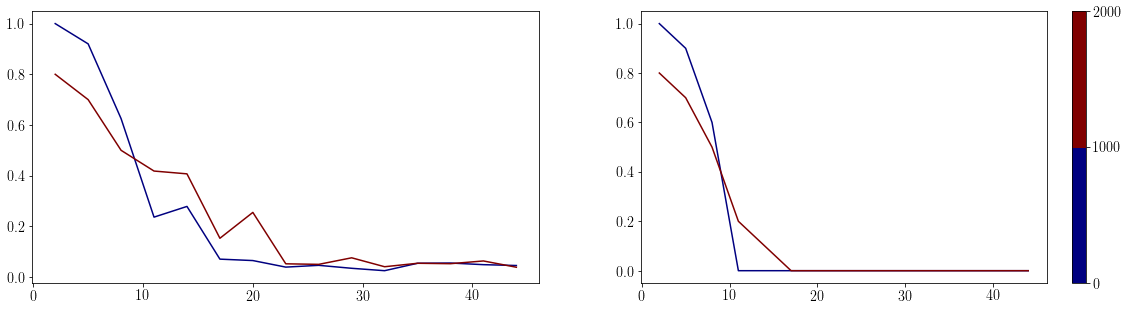

In [142]:
def sinus2d(x, y):
    return np.sin(x) + np.sin(y)

rows = len(f['accs'])

columns = 2
test_N = [1000*(2**i) for i in range(2)]
numN = len(test_N)

cols = get_cmap("jet", numN)
print cols
xaxis = [i for i in range(2,len(word),3)]
    
fig, axes = plt.subplots(rows, columns, sharex='all', squeeze=True, figsize=(20,5))

# x, y = [], []
# for k in range(numN):
#     x.append(xaxis)
#     y.append(list(f['accs'][0][k][:len(xaxis)]))
    
# sc = plt.scatter(x, y, cmap=cols)
# plt.colorbar(sc)
# plt.show()

for k in range(numN):
    axes[0].plot(xaxis, f['accs'][0][k][:len(xaxis)], c=cols(k))
    axes[1].plot(xaxis, f['binaccs'][0][k][:len(xaxis)], c=cols(k))


sm = plt.cm.ScalarMappable(cmap=cols)#, norm=plt.Normalize(vmin=0, vmax=1))
sm._A = []
cbar = fig.colorbar(sm, boundaries=[0] + test_N)


# m0=int(np.floor(test_N.min()))            # colorbar min value
# m4=int(np.ceil(test_N.max()))             # colorbar max value
# m1=int(1*(m4-m0)/4.0 + m0)               # colorbar mid value 1
# m2=int(2*(m4-m0)/4.0 + m0)               # colorbar mid value 2
# m3=int(3*(m4-m0)/4.0 + m0)               # colorbar mid value 3
# cbar.set_ticks([m0,m1,m2,m3,m4])
# cbar.set_ticklabels([m0,m1,m2,m3,m4])

plt.show()

In [ ]:
x, y = [], []
for k in range(numN):
    x += xaxis
    y += list(f['accs'][0][k][:len(xaxis)])
    
    
X, Y = np.meshgrid(x, y)

ax = plt.subplot(111)
im = ax.imshow(Y)

cax = divider.append_axes("right", size="5%", pad=0.05)

plt.colorbar(im, cax=cax)


NameError: name 'LinearSegmentedColormap' is not defined

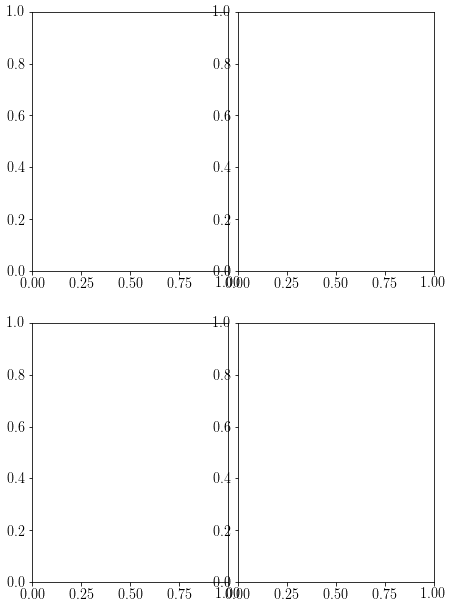

In [29]:
def resplot_im(coef_hists, nsteps=None):
    
    alphis = []
    for i in range(len(coef_hists)):
        if nsteps is None:
            alphis.append(np.argmax(np.abs(coef_hists[i][-1,:])))
        else:
            alphis.append(np.argmax(np.abs(coef_hists[i][nsteps,:])))
    
    rows = 1
    columns = len(coef_hists)
    
    fig = gcf();
    
    #fig, axes = plt.subplots(rows, columns, squeeze=True, figsize=(12,3))
    cols = get_cmap('copper', min(500,n_steps))
    
    for j in range(columns):
        ax = fig.add_subplot(rows, columns, j+1)
        if nsteps is not None:
            a = np.sign(coef_hists[j][nsteps,alphis[j]])
            coef_hists[j][:,alphis[j]] *= a
        
            x_h = coef_hists[j][:nsteps, :]    
        else:
            a = np.sign(coef_hists[j][-1,alphis[j]])
            coef_hists[j][:,alphis[j]] *= a
        
            x_h = coef_hists[j][:,:]
        
        ax.imshow(x_h, interpolation='none', aspect='auto', cmap=colormaps.viridis)
        
        #ax.invert_yaxis()
        
        #y_idxs = np.round(np.linspace(0, coef_hists[j].shape[1], 10))
        #y_labels = np.array(list(alph))[y_idxs]
        #ax.set_yticks(y_idxs)
        #axes[j].set_yticklabels(y_labels)
        if j == 0:
            ax.set_ylabel('Iterations')
        else:
            ax.set_yticks([])
            
        ax.set_title(alphis[j])
        #step, alphi = np.unravel_index(coef_hists[j].argmax(), coef_hists[j].shape)
        #axes[j].plot(alphi, coef_hists[j][step, alphi], '+')
    
    plt.tight_layout()
    

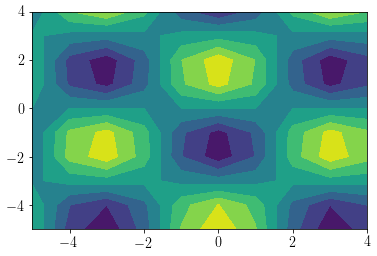

In [52]:
x = np.arange(-5, 5)#, 0.1)
y = np.arange(-5, 5)#, 0.1)
xx, yy = np.meshgrid(x, y, sparse=True)
z = np.cos(xx) * np.sin(yy)
h = plt.contourf(x,y,z)

In [58]:
nx, ny = (3, 2)
x = np.linspace(0, 1, nx)
y = np.linspace(0, 1, ny)
xv, yv = np.meshgrid(x, y)
print (x, y)

plt.contourf(x,y,z)

(array([ 0. ,  0.5,  1. ]), array([ 0.,  1.]))


array([[ 0. ,  0.5,  1. ],
       [ 0. ,  0.5,  1. ]])

2
[2, 5, 8, 11, 14, 17, 20, 23, 26, 29, 32, 35, 38, 41, 44, 2, 5, 8, 11, 14, 17, 20, 23, 26, 29, 32, 35, 38, 41, 44]
[1.0, 0.91999999999999993, 0.625, 0.23636363636363633, 0.27857142857142858, 0.070588235294117646, 0.065000000000000002, 0.039130434782608692, 0.046153846153846156, 0.034482758620689655, 0.025000000000000001, 0.054285714285714284, 0.055263157894736833, 0.04878048780487805, 0.045454545454545456, 0.80000000000000004, 0.69999999999999996, 0.5, 0.41818181818181815, 0.40714285714285714, 0.15294117647058825, 0.255, 0.052173913043478258, 0.050000000000000003, 0.07586206896551724, 0.040625000000000001, 0.054285714285714284, 0.052631578947368418, 0.063414634146341478, 0.038636363636363635]


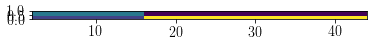

In [76]:
test_N = f['accs'][0]
numN = len(test_N)
xaxis = [i for i in range(2,len(word),3)]

x, y = [], []

for k in range(numN):
    x += xaxis
    y += list(f['accs'][0][k][:len(xaxis)])
#x, y = np.zeros(30), np.zeros(30)
heatmap, xedges, yedges = np.histogram2d(x, y, bins=3)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
print numN
print x
print y
plt.clf()
plt.imshow(heatmap.T, extent=extent, origin='lower')
plt.show()